In [2]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
import numpy as np
import random

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import pandas as pd
import sys
sys.path.append("../")
from qmg.utils import MoleculeQuantumStateGenerator

num_heavy_atom = 2
data_path = f"../dataset/chemical_space/effective_{num_heavy_atom}.csv"
data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=num_heavy_atom, ncpus=16)
data = pd.read_csv(data_path)
data.head()

,decimal_index,smiles
0,4,C
1,8,O
2,12,N
3,16,C
4,21,CC


/tmp/ipykernel_716512/873662604.py:53: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  results = execute(qc, backend=simulator, shots=4096).result()


12


/beegfs/home/lungyi45/.conda/envs/qmg/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


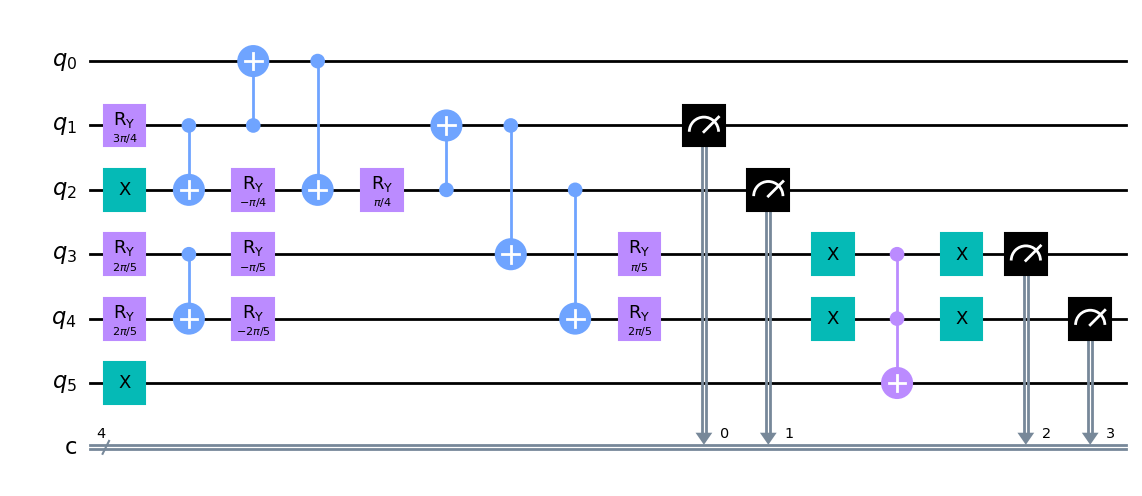

In [51]:
def controlled_ry(qc, control, target, digit):
    # Apply H to target if control is |1>
    qc.ry(-np.pi/2 * digit, target)
    qc.cx(control, target)
    qc.ry(np.pi/2 * digit, target)

def build_start_atom(qc, weight_1, weight_2):
    qc.ry(np.pi * weight_1, 1)
    qc.x(2)
    qc.cx(1, 2)
    qc.cx(1, 0)
    controlled_ry(qc, 0, 2, weight_2)
    qc.cx(2, 1)

def build_second_atom(qc, weight_1, weight_2, weight_3, weight_4):
    qc.ry(np.pi * weight_1, 3)
    qc.ry(np.pi * weight_2, 4)
    qc.cx(3,4)
    controlled_ry(qc, 1, 3, weight_3)
    controlled_ry(qc, 2, 4, weight_4)
    qc.x(3)
    qc.x(4)
    qc.x(5)
    qc.ccx(3,4,5) # store the |00> state in ancilla qubit (fifth qubit).
    qc.x(3)
    qc.x(4)

def build_bond_type_circuit(qc, heavy_atom_number: int, weight_vector):
    num_target_qubit = (heavy_atom_number - 1) * 2
    # assert np.abs(np.sum(weight_vector) - 1) < 1e-5
    assert len(weight_vector) == num_target_qubit
    # ancilla qubit indicating the existence of heavy_atom_number
    ancilla_qubit_number = 2*heavy_atom_number + (heavy_atom_number-1)**2 - 1
    for i in range(2*(heavy_atom_number-1)):
        qc.cx(ancilla_qubit_number+i, ancilla_qubit_number+i+1)
    for i in range(2*(heavy_atom_number-1)):
        controlled_ry(qc, ancilla_qubit_number+num_target_qubit-i-1, ancilla_qubit_number+num_target_qubit-i, 1-weight_vector[-1-i])
    

# def build_bond_type(qc, )

# 创建一个有三个量子位的量子电路
qc = QuantumCircuit(6, 4)
build_start_atom(qc, 0.75, 0.5)
build_second_atom(qc, 0.4, 0.4, 0.4, 0.8)
# 测量所有量子位
qc.measure([1,2,3,4], [0,1,2,3])

# 执行量子电路
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit)
results = execute(qc, backend=simulator, shots=4096).result()
counts = results.get_counts(qc)

print(len(counts))
# 绘制直方图
plot_histogram(counts)
qc.draw(output="mpl")

In [ ]:
plot_histogram(counts)

[0, 1, 2, 3, 5, 6]


/tmp/ipykernel_716512/2185613451.py:93: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  results = execute(qc, backend=simulator, shots=4096*4).result()


30


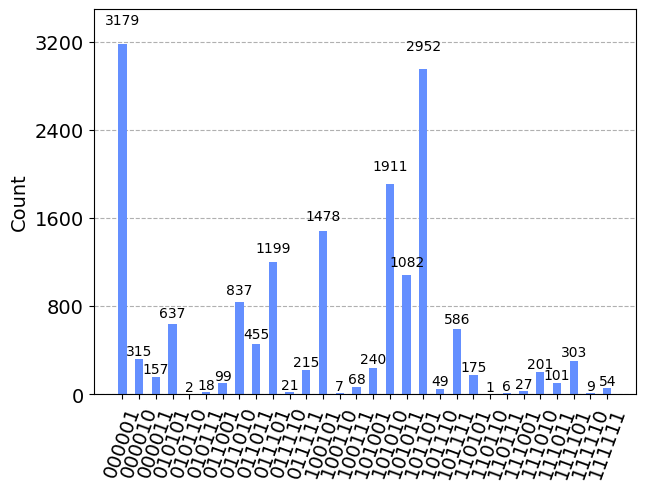

In [87]:
from typing import List, Union
import numpy as np

def controlled_ry(qc, control, target, digit):
    # Apply H to target if control is |1>
    qc.cry(np.pi*digit, control,target)
    # qc.ry(-np.pi/2 * digit, target)
    # qc.cx(control, target)
    # qc.ry(np.pi/2 * digit, target)

def build_two_atoms(qc, weight_vector: Union[List[float], np.ndarray]):
    assert len(weight_vector) == 8
    qc.ry(np.pi * weight_vector[0], 0)
    qc.x(1)
    qc.ry(np.pi * weight_vector[2], 2)
    qc.ry(np.pi * weight_vector[4], 3)
    qc.cx(0, 1)
    controlled_ry(qc, 1, 2, weight_vector[3])
    qc.cx(2, 3)
    controlled_ry(qc, 0, 1, weight_vector[1])
    qc.cx(1, 2)
    controlled_ry(qc, 2, 3, weight_vector[5])

    qc.x(2)
    qc.x(3)
    qc.x(4)
    qc.ccx(2,3,4) # store the |00> state in ancilla qubit (fourth qubit).
    qc.x(2)
    qc.x(3)

    qc.cx(4, 5)
    qc.cx(5, 6)
    controlled_ry(qc, 4, 5, weight_vector[6])
    qc.cx(5, 6)
    controlled_ry(qc, 5, 6, weight_vector[7])

def build_bond_type_circuit(qc, heavy_atom_number: int, fixed_weight_vector: Union[List[float], np.ndarray],
                            flexible_weight_vector: Union[List[float], np.ndarray]):
    num_target_qubit = (heavy_atom_number - 1) * 2
    # assert np.abs(np.sum(weight_vector) - 1) < 1e-5
    assert len(fixed_weight_vector)*2 == num_target_qubit == len(flexible_weight_vector)
    # ancilla qubit indicating the existence of heavy_atom_number
    ancilla_qubit_index = 2*heavy_atom_number + (heavy_atom_number-1)**2 - 1
    for i in range(2*(heavy_atom_number-1)):
        qc.cx(ancilla_qubit_index+i, ancilla_qubit_index+i+1)
    for i in range((heavy_atom_number-1)):
        controlled_ry(qc, ancilla_qubit_index+num_target_qubit-2*i-1, ancilla_qubit_index+num_target_qubit-2*i, 1-fixed_weight_vector[-1-i])
        qc.cx(ancilla_qubit_index+num_target_qubit-2*i-2, ancilla_qubit_index+num_target_qubit-2*i-1)
        controlled_ry(qc, ancilla_qubit_index+num_target_qubit-2*i, ancilla_qubit_index+num_target_qubit-2*i-1, flexible_weight_vector[-2-2*i])
        controlled_ry(qc, ancilla_qubit_index+num_target_qubit-2*i-1, ancilla_qubit_index+num_target_qubit-2*i, flexible_weight_vector[-1-2*i])
        # controlled_ry(qc, ancilla_qubit_index+2*i+1, ancilla_qubit_index+2*i+2, 1-fixed_weight_vector[i])
        # controlled_ry(qc, ancilla_qubit_index+2*i+2, ancilla_qubit_index+2*i+1, flexible_weight_vector[2*i])
        # controlled_ry(qc, ancilla_qubit_index+2*i+1, ancilla_qubit_index+2*i+2, flexible_weight_vector[2*i+1])


def build_atom_type_circuit(qc, heavy_atom_number: int, weight_vector: Union[List[float], np.ndarray]):
    assert len(weight_vector) == 3
    ancilla_qubit_index = 2*(heavy_atom_number-1) + (heavy_atom_number-2)**2 - 1
    qubit_1_index = ancilla_qubit_index + 2*(heavy_atom_number - 2) + 1
    qubit_2_index = qubit_1_index + 1
    qc.cx(ancilla_qubit_index, qubit_1_index)
    controlled_ry(qc, qubit_1_index, qubit_2_index, weight_vector[1])
    controlled_ry(qc, ancilla_qubit_index, qubit_1_index, weight_vector[0])
    qc.cx(qubit_2_index, qubit_1_index)
    controlled_ry(qc, qubit_1_index, qubit_2_index, weight_vector[2])
    
    qc.x(qubit_1_index)
    qc.x(qubit_2_index)
    qc.x(qubit_2_index+1)
    qc.ccx(qubit_1_index,qubit_2_index,qubit_2_index+1) # store the |00> state in ancilla qubit.
    qc.x(qubit_1_index)
    qc.x(qubit_2_index)

    
num_heavy_atom = 2
num_qubits = num_heavy_atom*(num_heavy_atom+1)
num_ancilla_qubits = num_heavy_atom - 1
qc = QuantumCircuit(num_qubits+num_ancilla_qubits, num_qubits)
build_two_atoms(qc, [0.7, 0.3, 0.6, 0.3, 0.2, 0.6, 0.6, 0.3])
# build_bond_type_circuit(qc, 2, [0.5, 0.5])

effective_qubit_index = list(range(num_qubits+num_ancilla_qubits))
for j in range(2, num_heavy_atom+1):
    ancilla_qubit_number = 2*j + (j-1)**2 - 1
    effective_qubit_index.remove(ancilla_qubit_number)
print(effective_qubit_index)
qc.measure(effective_qubit_index, list(range(num_qubits)))

# 执行量子电路
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit)
results = execute(qc, backend=simulator, shots=4096*4).result()
counts = results.get_counts(qc)

print(len(counts))
plot_histogram(counts)
# qc.draw(output="mpl")

/beegfs/home/lungyi45/.conda/envs/qmg/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


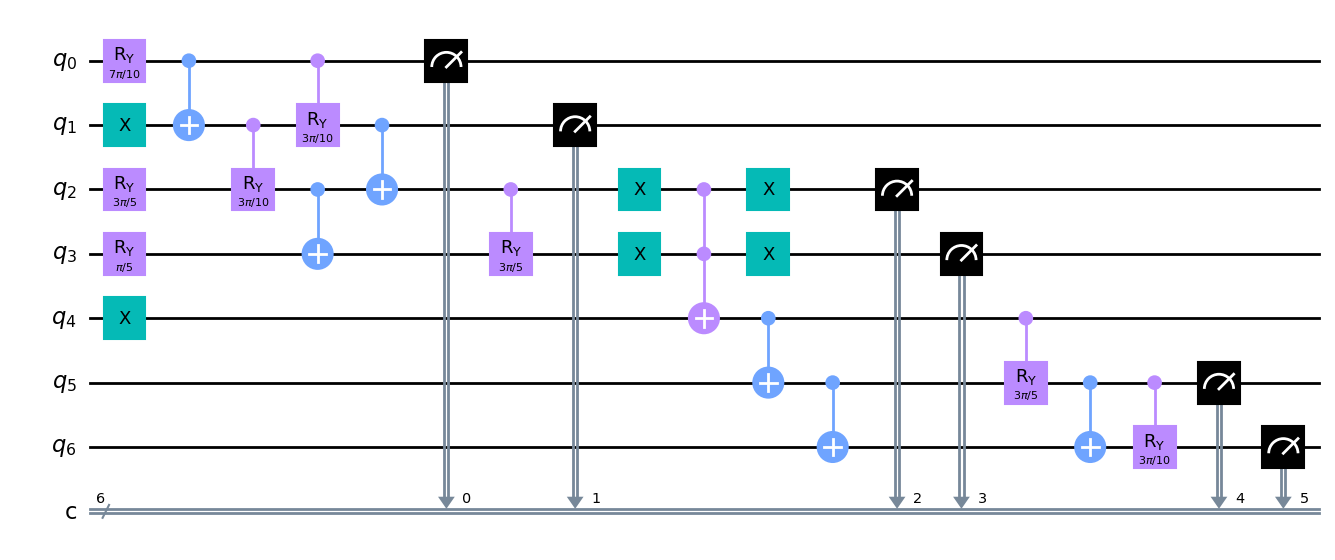

In [69]:
qc.draw(output="mpl")

## 3 heavy atoms

In [92]:
num_heavy_atom = 4
num_qubits = num_heavy_atom*(num_heavy_atom+1)
num_ancilla_qubits = num_heavy_atom - 1
qc = QuantumCircuit(num_qubits+num_ancilla_qubits, num_qubits)
build_two_atoms(qc, [0.7, 0.3, 0.6, 0.3, 0.2, 0.6, 0.6, 0.3])
# build_bond_type_circuit(qc, 2, [0.5, 0.5])
if num_heavy_atom - 2:
    for heavy_idx in range(3, num_heavy_atom+1):
        atom_type_weight_vector = [random.random() for _ in range(3)]
        bond_type_fixed_weight_vector = np.array([random.random() for _ in range((heavy_idx-1))])
        bond_type_fixed_weight_vector = bond_type_fixed_weight_vector / np.sum(bond_type_fixed_weight_vector)
        # bond_type_fixed_weight_vector = bond_type_fixed_weight_vector / 2
        print(bond_type_fixed_weight_vector)

        bond_type_flexible_weight_vector = np.array([random.random() for _ in range((heavy_idx-1)*2)])
        build_atom_type_circuit(qc, heavy_idx, atom_type_weight_vector)
        build_bond_type_circuit(qc, heavy_idx, bond_type_fixed_weight_vector, bond_type_flexible_weight_vector)


effective_qubit_index = list(range(num_qubits+num_ancilla_qubits))
for j in range(2, num_heavy_atom+1):
    ancilla_qubit_number = 2*j + (j-1)**2 - 1
    effective_qubit_index.remove(ancilla_qubit_number)
print(effective_qubit_index)
qc.measure(effective_qubit_index, list(range(num_qubits)))

# 执行量子电路
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit)
results = execute(qc, backend=simulator, shots=4096*8).result()
counts = results.get_counts(qc)

data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=num_heavy_atom, ncpus=16)
print(len(counts))
# plot_histogram(counts)
# qc.draw(output="mpl")

[0.37377741 0.62622259]
[0.13760211 0.16091119 0.7014867 ]
[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22]


/tmp/ipykernel_716512/2788102388.py:31: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  results = execute(qc, backend=simulator, shots=4096*8).result()


2609


/beegfs/home/lungyi45/.conda/envs/qmg/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


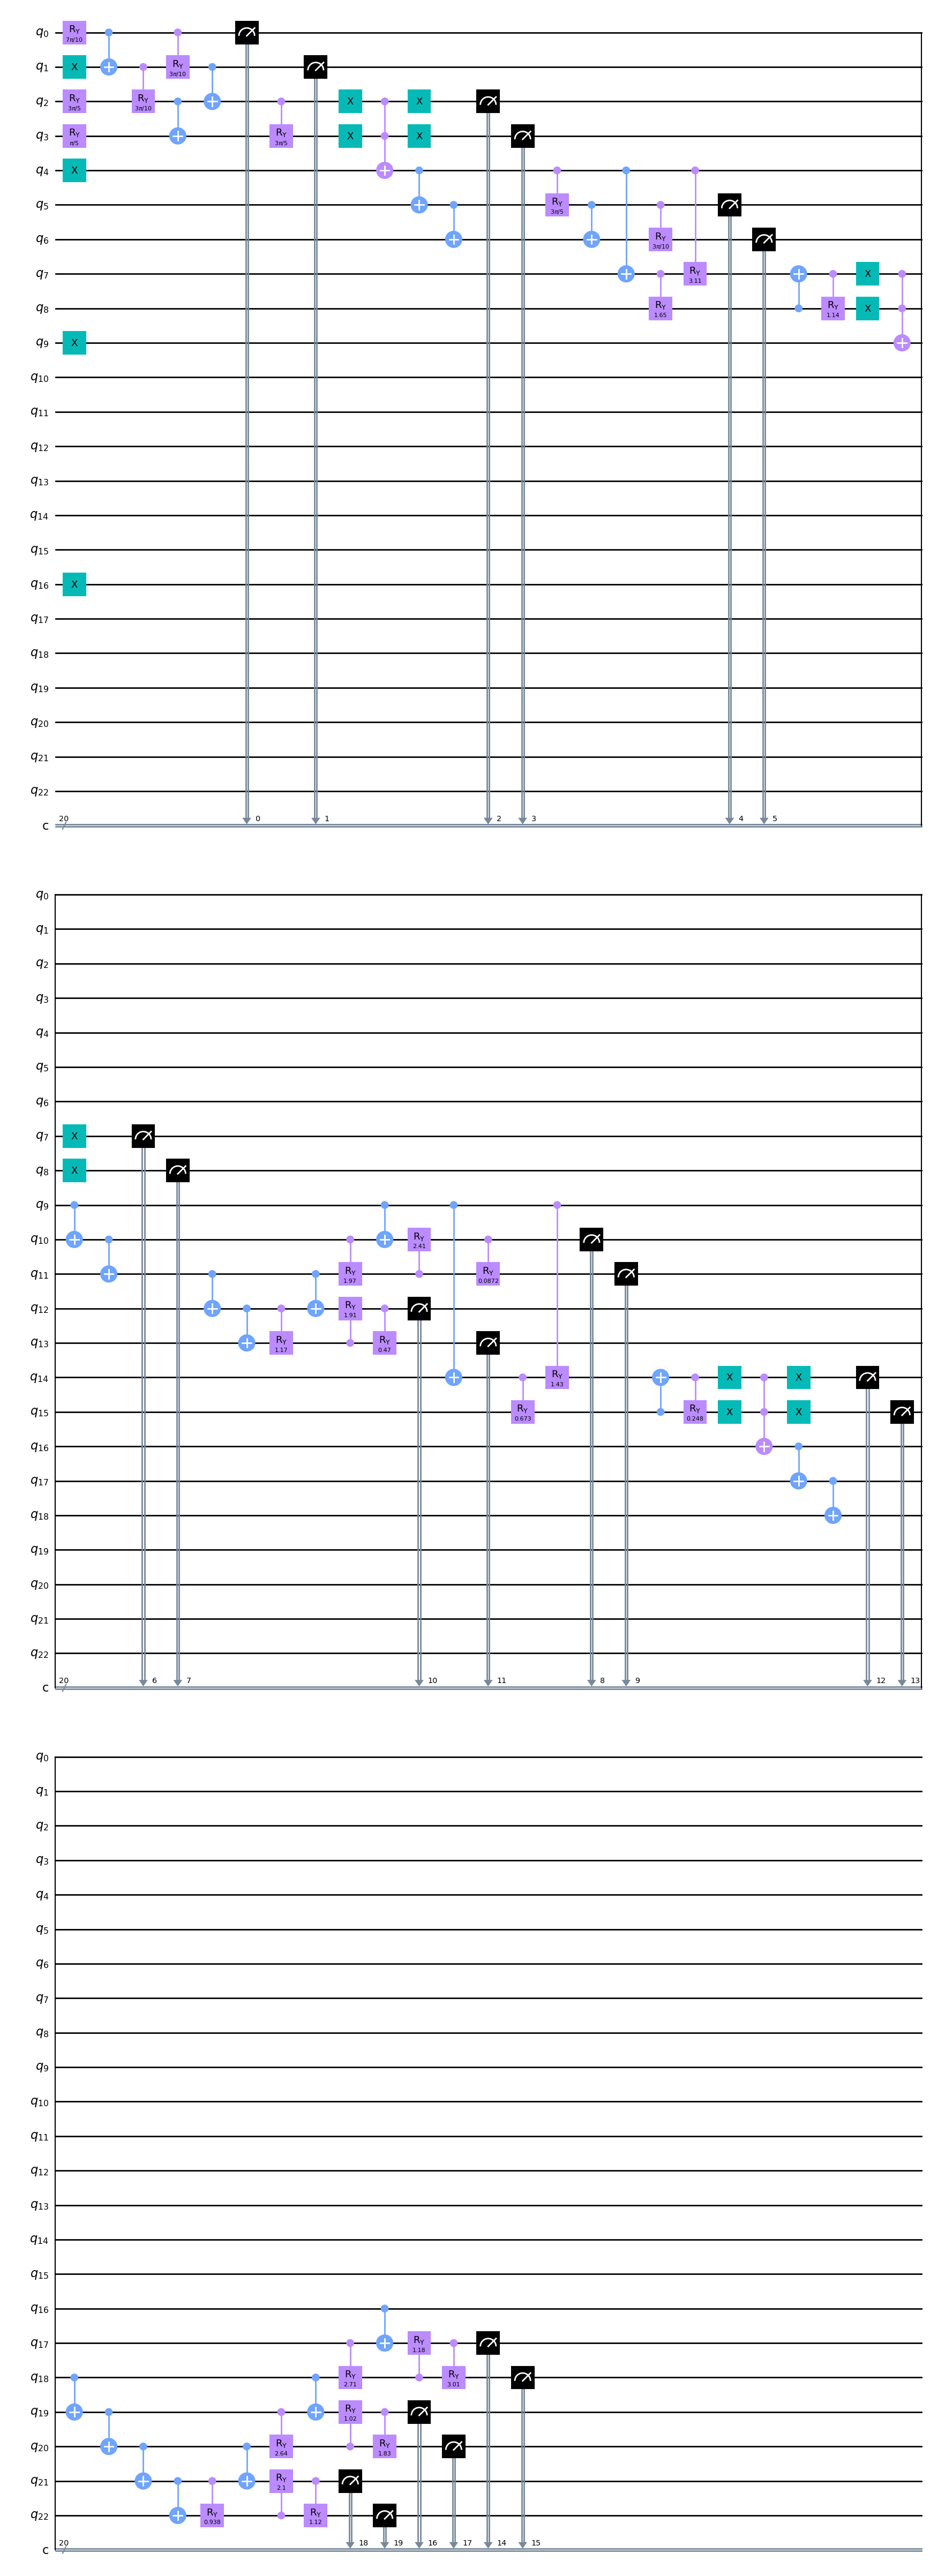

In [94]:
qc.draw(output="mpl")

In [93]:
def post_process_quantum_state(result_state: str, num_heavy_atom: int):
    """
    Reverse the qiskit outcome state and change the order to meet the definition of node vector and adjacency matrix.

    :param result_state: computational state derived from qiskit measurement outcomes
    :return: str of post-processed quantum state
    """
    assert len(result_state) == num_heavy_atom*(num_heavy_atom+1)
    result_state = result_state[::-1]
    quantum_state = ""
    for i in range(num_heavy_atom):
        atom_start_idx = i*2 + i*(i-1)
        quantum_state += result_state[atom_start_idx:atom_start_idx+2]
    for i in range(1, num_heavy_atom):
        for a_k, j in enumerate(range(i, num_heavy_atom)):
            bond_start_idx = (i+1)*2 + 2*a_k + j*(j-1) + (i-1)*2
            quantum_state += result_state[bond_start_idx:bond_start_idx+2]
    return quantum_state

data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=num_heavy_atom, ncpus=16)
smiles_list = []
for key, value in counts.items():
    # quantum_state = key[::-1]
    # smiles = data_generator.QuantumStateToSmiles(quantum_state)
    # print(quantum_state, value)
    print(key[::-1], post_process_quantum_state(key, num_heavy_atom), value)
    smiles = data_generator.QuantumStateToSmiles(post_process_quantum_state(key, num_heavy_atom))
    print(smiles)
    smiles_list.append(smiles)
print(set(smiles_list))

10100111000011000011 10101111010000000011 1
N#N.OO
11111010001000000000 11111000100000100000 1
None
10101011111110010011 10101110101101110011 1
None
11011011001111000000 11011111100000110000 1
None
10100111001010000110 10101110010000100110 1
None
10101111110010000000 10101110111100000000 1
None
11010111010110000011 11011110010100010011 1
None
10110111110010000110 10111110011100000110 1
None
10011011111101000001 10011101101100110001 1
None
01010110001010000001 01011010010000100001 1
None
11010110001110010001 11011010010001110001 1
None
10110110000010001100 10111010010000001100 1
None
10110111110110000101 10111110011100010101 1
None
10110110111101000001 10111001011100110001 1
None
01011111110110100011 01011110111110010011 1
None
01011011001110000100 01011110100000110100 1
None
11111011001101000010 11111101100000110010 1
None
01100111000110000011 01101110010000010011 1
None
11011011110110000100 11011110101100010100 1
None
10101011010110000011 10101110100100010011 2
None
010110101100100100